# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [1]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd

# Options

In [2]:
data_date_oi = "15Dec22"
load_noise = True      #The gold standard of noise realizations is standardNoise_28Nov22.pkl
noise_date_oi = "28Nov22"

SNR_option = 20

explore_corners = False

eval_nonReg = True
eval_orc_avg = True
eval_minErr = True
eval_GCV = True


post_normalize_data = False

# Define Parameters

In [3]:
with open('SimulationSets//hprParameter_info_' + data_date_oi + '.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    SNR_mat = dict['SNR_mat']
    n_noise_realizations = dict['n_noise_realizations']
    num_multistarts = dict['num_multistarts']
    lambdas = dict['lambdas']
    tdata = dict['tdata']
    c1_set = dict['c1_set']
    T21_set = dict['T21_set']
    T22_set = dict['T22_set']
    noise_date_oi = dict["noise_date_oi"]
    ob_weight = dict['ob_weight']
    upper_bound = dict['upper_bound']
    handle.close()

n_elements = len(tdata)

agg_weights = np.array([1, 1, 1/ob_weight, 1/ob_weight])

###################### Parameters Loop Through

param_name_list = ['c1','c2','T21','T22']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

# Define General Functions

### Small Helper Functions

In [4]:
########################### Simple Functions ##############################
# Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def construct_paramList(c1_list, T21_list, T22_list):
    preList = [item for item in itertools.product(c1_list, T21_list, T22_list)]
    postList = [list(elem) for elem in preList]
    [elem.insert(1,1-elem[0]) for elem in postList]
    return postList

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calc_improvement(old, new):
    return (old - new)/old

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,4))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

def to_readable(file):
    df = pd.read_feather(file)
    ALL_ESTIMATES = np.stack(df["Estimates"].values) #shape: (index, noise_realization, lambda, popt)
    ALL_RES = np.stack(df["RSS"].values) #shape: (index, noise_realization, lambda, residual)
    ALL_PARAMS = np.stack(df["TrueParams"].values) #(index, 4)
    return ALL_PARAMS, ALL_ESTIMATES, ALL_RES

### Parameter Estimation Functions

In [5]:
def estimate_parameters(data, lam, n_initials = num_multistarts):
    #Pick n_initials random initial conditions within the bound, and choose the one giving the lowest model-data mismatch residual
    random_residuals = []
    estimates = np.zeros((4,n_initials))
    data_start = np.abs(data[0])
    data_tilde = np.append(data, [0,0,0,0]) # Adds zeros to the end of the regularization array for the param estimation
    
    for i in range(n_initials):
        np.random.seed(i)
        ic1 = np.random.uniform(0,1)
        ic2 = 1-ic1
        ic1 = ic1*data_start
        ic2 = ic2*data_start
        iT21 = np.random.uniform(0,upper_bound[-2])
        iT22 = np.random.uniform(iT21,upper_bound[-1])
        p0 = [ic1,ic2,iT21,iT22]
        up_bnd = upper_bound*np.array([data_start, data_start, 1, 1])
        assert(np.size(up_bnd) == np.size(p0))
        
        try:
            popt, cov = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (0, up_bnd), p0=p0, max_nfev = 4000)
        except:
            popt = [0,0,1,1]
            print("Max feval reached")
        
        popt = check_param_order(popt) #Require T22>T21
        estimates[:,i] = popt
        estimated_model = G(tdata, *popt)
        
        residual = np.sum((estimated_model - data)**2)
        random_residuals.append(residual)
    min_residual_idx = np.argmin(random_residuals)
    min_residual_estimates = estimates[:,min_residual_idx]
 
    return min_residual_estimates

def generate_all_estimates(param_combos, SNR_mat, noise_mat, lambdas, n_NR = n_noise_realizations):
    #Generates a comprehensive matrix of all parameter estimates for all param combinations, 
    #noise realizations, SNR values, and lambdas of interest

    all_estimates = np.zeros((len(param_combos),len(SNR_mat), len(noise_mat), len(lambdas), 4))
    all_RSS = np.zeros((len(param_combos),len(SNR_mat), len(noise_mat), len(lambdas)))
    
    for iCombo in trange(len(param_combos)): #Loop through all parameter combinations
        pCombo = param_combos[iCombo]
        underlying = G(tdata, *pCombo)

        for iSNR in range(len(SNR_mat)):    #Loop through different SNR values
            all_noise = underlying + (1/SNR_mat[iSNR])*noise_mat
            assert(all_noise.shape == noise_mat.shape)

            for nr in range(n_NR):    #Loop through all noise realizations
                noise_data = all_noise[nr,:]

                for iLam in range(len(lambdas)):    #Loop through all lambda values
                    lam = lambdas[iLam]
                    param_estimates = estimate_parameters(noise_data, lam)
                    all_estimates[iCombo, iSNR, nr, iLam, :] = param_estimates

                    estimated_model = G(tdata, *param_estimates)
                    all_RSS[iCombo, iSNR, nr, iLam] = np.sum((estimated_model - noise_data)**2)

    return all_estimates, all_RSS

In [6]:
##### Regularization Functions on Stored Data

def pull_avgNR(true_combos, est_combos):
    true_combos = np.array(true_combos)
    bias_hold_array = np.zeros(est_combos.shape)
    for iter in range(bias_hold_array.shape[0]):
        bias_hold_array[iter,:] = est_combos[iter,:] - true_combos[iter, :]
    bias = np.mean(bias_hold_array, axis = 1) #average the bias across all noise realizations
    variance = np.var(est_combos, axis = 1) #obtains the variance across all noise realizations
    return bias, variance

def match_index(index_array, bias, var):
    return_bias = np.zeros(index_array.shape)
    return_var = np.zeros(index_array.shape)
    for iPC in range(index_array.shape[0]):
        if len(index_array.shape)>1:
            for iParam in range(index_array.shape[-1]):
                return_bias[iPC, iParam] = bias[iPC, index_array[iPC, iParam],iParam] 
                return_var[iPC, iParam] = var[iPC, index_array[iPC, iParam],iParam]
        else:
            return_bias[iPC] = bias[iPC, index_array[iPC]] 
            return_var[iPC] = var[iPC, index_array[iPC]]
    return return_bias, return_var


def pull_orc_minErr(true_combos, est_combos):
    true_combos = np.array(true_combos)
    sqError_hold_array = np.zeros(est_combos.shape)
    sqError_agg_hold_array = np.zeros(est_combos.shape[0:-1])
    for iter in range(sqError_hold_array.shape[0]):
        error = np.absolute(est_combos[iter,:] - true_combos[iter, :]) #This absolute value doesn't seem necessary
        sqError_hold_array[iter,:] = (error)**2
        sqError_agg_hold_array[iter,:] = np.sum((agg_weights*error)**2, axis = -1)
    minError_index = np.argmin(sqError_hold_array, axis = -2)
    minError_agg_index = np.argmin(sqError_agg_hold_array, axis = -1)

    return minError_index, minError_agg_index

def match_index_orc2(index_array, params):
    best_indices = index_array.shape
    return_params = np.zeros(np.append(index_array.shape,4))
    for iPC in range(index_array.shape[0]):
        for iNR in range(index_array.shape[1]):
            if len(index_array.shape)>2:
                for iParam in range(index_array.shape[-1]):
                    return_params[iPC, iNR, iParam, :] = params[iPC, iNR, index_array[iPC, iNR, iParam]]
            else:
                return_params[iPC, iNR, :] = params[iPC, iNR, index_array[iPC, iNR]] 
    return return_params

def get_GCV_value(params, RSS, lamb):

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    GCVjacobian = J(tdata, *params)
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(lamb**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)
    GCVdenominator = (identity - C_GCV).trace()
    GCV = RSS/(GCVdenominator**2)
    return GCV

def pull_GCV(true_combos, est_combos, RSS_combos, lambda_array):
    true_combos = np.array(true_combos)

    n_pCombos, n_NR = est_combos.shape[0:2]
    
    GCV_hold_values = np.zeros(len(lambda_array))
    GCV_final_lam = np.zeros((n_pCombos, n_NR))
    GCV_final_params = np.zeros((n_pCombos, n_NR, 4))

    for iCombo in trange(n_pCombos): #Loop through all parameter combinations

        count_singular = 0

        for nr in range(n_NR):    #Loop through all noise realizations

            for iLam in range(len(lambda_array)):    #Loop through all lambda values
                one_param_combo = est_combos[iCombo, nr, iLam, :]
                one_param_RSS = RSS_combos[iCombo, nr, iLam]
                if lambda_array[iLam] == 0:
                    GCV_hold_values[iLam] = np.inf
                else:
                    try:
                        GCV_hold_values[iLam] = get_GCV_value(one_param_combo, one_param_RSS, lambda_array[iLam])
                    except:
                        GCV_hold_values[iLam] = np.inf
                        count_singular += 1

            min_GCV_index = np.argmin(GCV_hold_values)   
            GCV_final_params[iCombo, nr,:] = est_combos[iCombo, nr, min_GCV_index, :]
            GCV_final_lam[iCombo, nr] = lambda_array[min_GCV_index]
        if count_singular >0:
            print(f"Combo = {iCombo} had {count_singular} singular GCV values associated with nonzero lambda values")

    bias_hold_array = np.zeros(GCV_final_params.shape)
    for iter in range(bias_hold_array.shape[0]):
        bias_hold_array[iter,:] = GCV_final_params[iter,:] - true_combos[iter, :]
    bias = np.mean(bias_hold_array, axis = 1) #average the bias across all noise realizations
    variance = np.var(GCV_final_params, axis = 1) #obtains the variance across all noise realizations
    
    return bias, variance, GCV_final_lam, GCV_final_params

# Generate Data Sets

In [7]:
data_name = f"SimulationSets/runInfo_SNR_{SNR_option}_" + data_date_oi +".feather"

print("Retrieving data for " + data_name)
params, estimates, RSS = to_readable(data_name)

Retrieving data for SimulationSets/runInfo_SNR_20_15Dec22.feather


In [8]:
params_rs = np.reshape(params,(175,500,52,-1))
params_rs = params_rs[:,0,0,:]
estimates_rs = np.reshape(estimates,(175,500,52,-1))
RSS_rs = np.reshape(RSS,(175,500,52))

In [9]:
paramCombos = construct_paramList(c1_set, T21_set, T22_set)
reorder_indices = np.zeros(len(paramCombos))

params_rs_list = params_rs.tolist()

for iPC in range(len(paramCombos)):
    PC = paramCombos[iPC]
    print(PC)
    reorder_indices[iPC] = params_rs_list.index(PC)
    print(params_rs_list.index(PC))
#reorder_indices is a list of the index in params_rs_list where that parameter combo shows up
#For example, index 76 corresponds to the index in params_rs that goes with [0,1,10,70]

[0.0, 1.0, 10, 70]
63
[0.0, 1.0, 10, 90]
88
[0.0, 1.0, 10, 110]
40
[0.0, 1.0, 10, 130]
50
[0.0, 1.0, 10, 150]
30
[0.0, 1.0, 20, 70]
73
[0.0, 1.0, 20, 90]
77
[0.0, 1.0, 20, 110]
87
[0.0, 1.0, 20, 130]
57
[0.0, 1.0, 20, 150]
11
[0.0, 1.0, 30, 70]
29
[0.0, 1.0, 30, 90]
90
[0.0, 1.0, 30, 110]
69
[0.0, 1.0, 30, 130]
42
[0.0, 1.0, 30, 150]
9
[0.0, 1.0, 40, 70]
52
[0.0, 1.0, 40, 90]
80
[0.0, 1.0, 40, 110]
72
[0.0, 1.0, 40, 130]
71
[0.0, 1.0, 40, 150]
10
[0.0, 1.0, 50, 70]
44
[0.0, 1.0, 50, 90]
26
[0.0, 1.0, 50, 110]
46
[0.0, 1.0, 50, 130]
59
[0.0, 1.0, 50, 150]
32
[0.2, 0.8, 10, 70]
48
[0.2, 0.8, 10, 90]
39
[0.2, 0.8, 10, 110]
21
[0.2, 0.8, 10, 130]
49
[0.2, 0.8, 10, 150]
54
[0.2, 0.8, 20, 70]
62
[0.2, 0.8, 20, 90]
34
[0.2, 0.8, 20, 110]
51
[0.2, 0.8, 20, 130]
43
[0.2, 0.8, 20, 150]
45
[0.2, 0.8, 30, 70]
70
[0.2, 0.8, 30, 90]
61
[0.2, 0.8, 30, 110]
38
[0.2, 0.8, 30, 130]
55
[0.2, 0.8, 30, 150]
36
[0.2, 0.8, 40, 70]
25
[0.2, 0.8, 40, 90]
83
[0.2, 0.8, 40, 110]
74
[0.2, 0.8, 40, 130]
33
[0.2, 0

In [10]:
#This checks to make sure that converting between lists and numpy arrays doesn't distort the data
hold1 = estimates_rs.tolist()
hold2 = np.array(hold1)
assert(np.all(estimates_rs == hold2))

In [11]:
###Rearrange all code to match the proper index

#the first entry of reordered_estimates should correspond to all estimates associated with
#the first parameter combo
temp_estimates = estimates_rs.tolist()
reordered_estimates = [temp_estimates[int(i)] for i in reorder_indices]
estimates_rs_ro = np.array(reordered_estimates)

temp_RSS = RSS_rs.tolist()
reordered_RSS = [temp_RSS[int(i)] for i in reorder_indices]
RSS_rs_ro = np.array(reordered_RSS)

temp_pC = params_rs.tolist()
reordered_pC = [temp_pC[int(i)] for i in reorder_indices]
params_rs_ro = np.array(reordered_pC)

In [12]:
#Visual check and complete check to make sure the ordering worked
print(estimates_rs_ro[0,0,0,:])
print(reorder_indices[0])
print(estimates_rs[int(reorder_indices[0]),0,0,:])
assert(np.all(estimates_rs_ro[0,:]==estimates_rs[int(reorder_indices[0]),:]))
assert(np.all(params_rs_ro == paramCombos))

[9.82621200e-01 1.49656689e-02 6.68122975e+01 2.16916081e+02]
63.0
[9.82621200e-01 1.49656689e-02 6.68122975e+01 2.16916081e+02]


In [13]:
#####Generate Noise 
if load_noise:
    with open('SimulationSets//standardNoise_' + noise_date_oi + '.pkl', 'rb') as handle:
        noise_mat = pickle.load(handle)
    handle.close()
    print("Noise Loaded")

Noise Loaded


In [14]:
if post_normalize_data:
    complete_estimates = post_normalize(estimates_rs)
    post_norm_blurb = "\nPost Normalized"
    print("Normalized Data")
else:
    print("Raw Data")
    post_norm_blurb = ""

Raw Data


# Calculate Improvement on All Cases

In [15]:
###Processing all estimates with oracle and GCV measures
if eval_nonReg or eval_orc_avg:
    start_time = time.time()
    orcAvg_bias, orcAvg_var = pull_avgNR(params_rs_ro, estimates_rs_ro)

    orcAvg_MSE = orcAvg_bias**2 + orcAvg_var
    orcAvg_agg_MSE = np.sum(orcAvg_MSE*agg_weights**2, axis = -1)
    minMSE_orcAvg_MSE = np.min(orcAvg_MSE, axis = 1)
    minMSE_orcAvg_MSE_index = np.argmin(orcAvg_MSE, axis = 1)
    minMSE_orcAvg_lamb = lambdas[minMSE_orcAvg_MSE_index]
    minMSE_orcAvg_bias, minMSE_orcAvg_var = match_index(minMSE_orcAvg_MSE_index, orcAvg_bias, orcAvg_var)
    
    minMSE_orcAvg_agg_MSE = np.min(orcAvg_agg_MSE, axis = 1)
    minMSE_orcAvg_agg_MSE_index = np.argmin(orcAvg_agg_MSE, axis = 1)
    minMSE_orcAvg_agg_lamb = lambdas[minMSE_orcAvg_agg_MSE_index]
    orcAvg_agg_bias_sq = np.sum(orcAvg_bias**2*agg_weights**2, axis = -1)
    orcAvg_agg_var = np.sum(orcAvg_var*agg_weights**2, axis = -1)
    minMSE_orcAvg_agg_bias_sq, minMSE_orcAvg_agg_var = match_index(minMSE_orcAvg_agg_MSE_index, orcAvg_agg_bias_sq, orcAvg_agg_var)

    ### All nonregularized calculations
    nonreg_bias = orcAvg_bias[:,0,:]
    nonreg_var = orcAvg_var[:,0,:]
    nonreg_agg_biasSq = np.sum(nonreg_bias**2*agg_weights**2, axis = -1)
    nonreg_agg_var = np.sum(nonreg_var*agg_weights**2, axis = -1)
    nonreg_MSE = orcAvg_MSE[:,0,:]
    assert(np.all(nonreg_MSE == nonreg_bias**2 + nonreg_var))
    nonreg_agg_MSE = np.sum(nonreg_MSE*agg_weights**2, axis = -1)

    orcAvg_imp_MSE = calc_improvement(nonreg_MSE, minMSE_orcAvg_MSE)
    orcAvg_imp_bias_sq = calc_improvement(nonreg_bias**2, minMSE_orcAvg_bias**2)
    orcAvg_imp_var = calc_improvement(nonreg_var, minMSE_orcAvg_var)
    orcAvg_agg_imp_MSE = calc_improvement(nonreg_agg_MSE, minMSE_orcAvg_agg_MSE)
    orcAvg_agg_imp_bias_sq = calc_improvement(nonreg_agg_biasSq, minMSE_orcAvg_agg_bias_sq)
    orcAvg_agg_imp_var = calc_improvement(nonreg_agg_var, minMSE_orcAvg_agg_var)

    print('Calc avgNR bias and var:', (time.time()-start_time), ' seconds')

if eval_minErr:
    start_time = time.time()
    minErr_index, minErr_agg_index = pull_orc_minErr(params_rs_ro, estimates_rs_ro)

    minErr_orcNR_lamb = lambdas[minErr_index]
    minErr_orcNR_agg_lamb = lambdas[minErr_agg_index]

    minErr_orcNR_params = match_index_orc2(minErr_index, estimates_rs_ro)
    minErr_orcNR_agg_params = match_index_orc2(minErr_agg_index, estimates_rs_ro)

    minErr_bias, minErr_var = pull_avgNR(params_rs_ro, minErr_orcNR_params)
    minErr_agg_bias, minErr_agg_var = pull_avgNR(params_rs_ro, minErr_orcNR_agg_params)

    minErr_agg_bias_sq_agg = np.sum(minErr_agg_bias**2*agg_weights**2, axis = -1)
    minErr_agg_var_agg = np.sum(minErr_agg_var*agg_weights**2, axis = -1)

    minErr_agg_MSE = minErr_agg_bias**2 + minErr_agg_var
    minErr_agg_MSE_agg = np.sum(minErr_agg_MSE*agg_weights**2, axis = -1)

    minErr_agg_imp_MSE = calc_improvement(nonreg_MSE, minErr_agg_MSE)
    minErr_agg_imp_bias_sq = calc_improvement(nonreg_bias**2, minErr_agg_bias**2)
    minErr_agg_imp_var = calc_improvement(nonreg_var, minErr_agg_var)

    minErr_agg_imp_MSE_agg = calc_improvement(nonreg_agg_MSE, minErr_agg_MSE_agg)
    minErr_agg_imp_bias_sq_agg = calc_improvement(nonreg_agg_biasSq, minErr_agg_bias_sq_agg)
    minErr_agg_imp_var_agg = calc_improvement(nonreg_agg_var, minErr_agg_var_agg)

    print('Orc 2 time:', (time.time()-start_time), ' seconds')

if eval_GCV:
    start_time = time.time()
    GCV_bias, GCV_var, GCV_lambdas, GCV_final_params = pull_GCV(params_rs_ro, estimates_rs_ro, RSS_rs_ro, lambdas)
    GCV_MSE = GCV_bias**2 + GCV_var
    GCV_agg_MSE = np.sum(GCV_MSE*agg_weights**2, axis = -1)

    GCV_imp_MSE = calc_improvement(nonreg_MSE, GCV_MSE)
    GCV_imp_bias_sq = calc_improvement(nonreg_bias**2, GCV_bias**2)
    GCV_imp_var = calc_improvement(nonreg_var, GCV_var)
    GCV_agg_imp_MSE = calc_improvement(nonreg_agg_MSE, GCV_agg_MSE)

    print('GCV time:', (time.time()-start_time), ' seconds')


Calc avgNR bias and var: 0.2530195713043213  seconds
Orc 2 time: 0.68947434425354  seconds


100%|██████████| 175/175 [05:58<00:00,  2.05s/it]

GCV time: 358.9374301433563  seconds


# Single Profile Selection

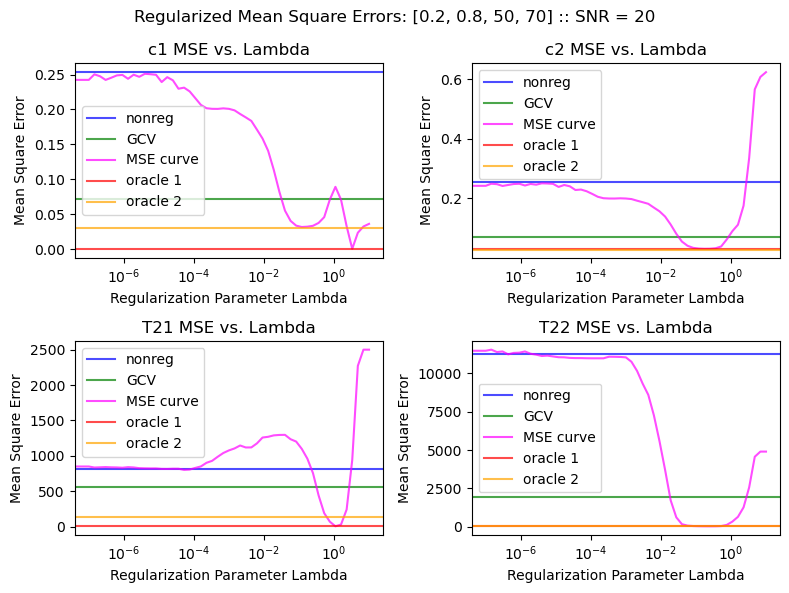

In [20]:
pCombo_oi = [0.2,0.8,50,70]
pC_index = paramCombos.index(pCombo_oi)

single_pC_GCV_MSE = GCV_MSE[pC_index,:]
single_pC_orcAvg = orcAvg_MSE[pC_index,:,:]
single_pC_orcAvg_min = np.min(single_pC_orcAvg, axis = 0)
single_pC_orcErr = minErr_agg_MSE[pC_index,:]
single_pC_nonReg = nonreg_MSE[pC_index,:]

plt.rc('font', size = 10)
fig, ax = plt.subplots(2,2, figsize=(8,6), tight_layout=True)
fig.suptitle('Regularized Mean Square Errors: ' + str(pCombo_oi) + ' :: SNR = ' + str(SNR_option) + post_norm_blurb)
for i in range(4):
    ax[i//2, i%2].axhline(y = single_pC_nonReg[i], label = "nonreg", alpha = 0.7, color = "blue")
    ax[i//2, i%2].axhline(y = single_pC_GCV_MSE[i], label = "GCV", alpha = 0.7, color = "green")
    ax[i//2, i%2].semilogx(lambdas, single_pC_orcAvg[:,i], label = "MSE curve", alpha = 0.7, color = "magenta")
    ax[i//2, i%2].axhline(y = single_pC_orcAvg_min[i], label = "oracle 1", alpha = 0.7, color = "red")
    ax[i//2, i%2].axhline(y = single_pC_orcErr[i], label = "oracle 2", alpha = 0.7, color = "orange")
    ax[i//2, i%2].set_xlabel('Regularization Parameter Lambda')
    ax[i//2, i%2].set_ylabel('Mean Square Error')
    ax[i//2, i%2].set_title(param_name_list[i] + ' MSE vs. Lambda')
    ax[i//2, i%2].legend()
plt.show()

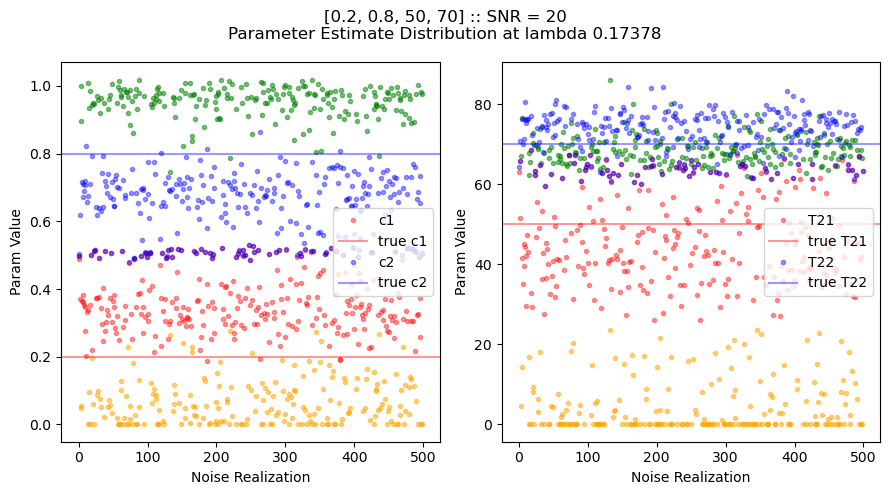

In [21]:
lambda_val_oi = np.mean(GCV_lambdas, axis = 1)[pC_index]

lambda_oi = np.argmin((lambdas - lambda_val_oi)**2)

T21_based_out_index = np.where(estimates_rs_ro[pC_index, :, lambda_oi, 2] < pCombo_oi[2]//2)

T21_based_in_index = np.setdiff1d(np.arange(0,500), T21_based_out_index)

plt.rc('font', size = 10)
fig, ax = plt.subplots(1, 2, figsize=(9,5), tight_layout=True)
fig.suptitle(str(pCombo_oi) + ' :: SNR = ' + str(SNR_option) + f"\nParameter Estimate Distribution at lambda {np.round(lambdas[lambda_oi],5)}" + post_norm_blurb)
ax[0].plot(T21_based_out_index, estimates_rs_ro[pC_index,T21_based_out_index, lambda_oi,0], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(T21_based_out_index, estimates_rs_ro[pC_index,T21_based_out_index, lambda_oi,1], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(T21_based_in_index, estimates_rs_ro[pC_index,T21_based_in_index, lambda_oi,0], color = "red", label = "c1", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[0], label = 'true c1', color = "red", alpha = 0.4)
ax[0].plot(T21_based_in_index, estimates_rs_ro[pC_index,T21_based_in_index, lambda_oi,1], color = "blue", label = "c2", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[1], label = 'true c2', color = "blue", alpha = 0.4)
ax[0].set_xlabel("Noise Realization")
ax[0].set_ylabel("Param Value")
ax[0].legend()

ax[1].plot(T21_based_out_index, estimates_rs_ro[pC_index,T21_based_out_index, lambda_oi,2], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T21_based_out_index, estimates_rs_ro[pC_index,T21_based_out_index, lambda_oi,3], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T21_based_in_index, estimates_rs_ro[pC_index,T21_based_in_index, lambda_oi,2], color = "red", label = "T21", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[2], label = 'true T21', color = "red", alpha = 0.4)
ax[1].plot(T21_based_in_index, estimates_rs_ro[pC_index,T21_based_in_index, lambda_oi,3], color = "blue", label = "T22", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[3], label = 'true T22', color = "blue", alpha = 0.4)
ax[1].set_xlabel("Noise Realization")
ax[1].set_ylabel("Param Value")
ax[1].legend()

#c1 outliers = 1 
#c2 outliers = 0 
#T21 outliers = 0 
#T22 outliers = 19


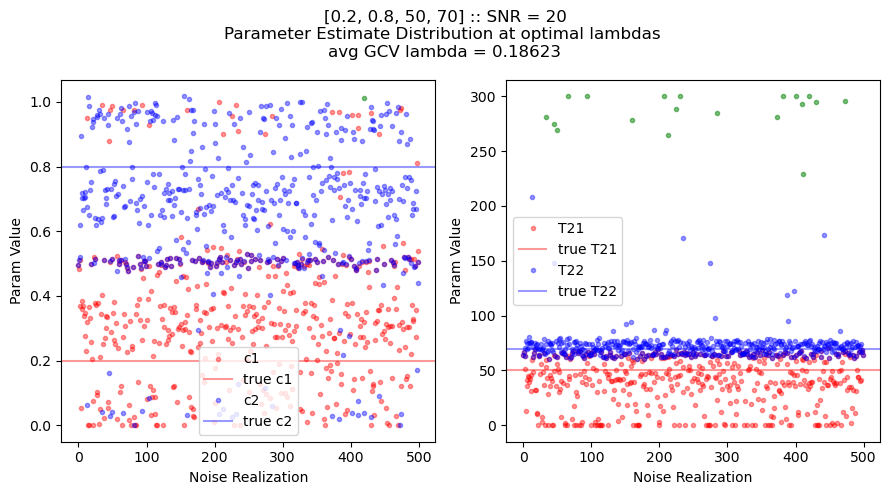

In [22]:
lambda_val_oi = np.mean(GCV_lambdas, axis = 1)[pC_index]

param_means = np.mean(GCV_final_params[pC_index, :], axis = 0)
param_std = np.std(GCV_final_params[pC_index, :], axis = 0)
param_topBar = param_means + 3*param_std
param_lowBar = param_means - 3*param_std

c1_outlier_index = np.array(np.where(np.logical_or(GCV_final_params[pC_index,:,0]<param_lowBar[0],GCV_final_params[pC_index,:,0]>param_topBar[0])))
c2_outlier_index = np.array(np.where(np.logical_or(GCV_final_params[pC_index,:,1]<param_lowBar[1], GCV_final_params[pC_index,:,1]>param_topBar[1])))
T21_outlier_index = np.array(np.where(np.logical_or(GCV_final_params[pC_index,:,2]<param_lowBar[2], GCV_final_params[pC_index,:,2]>param_topBar[2])))
T22_outlier_index = np.array(np.where(np.logical_or(GCV_final_params[pC_index,:,3]<param_lowBar[3], GCV_final_params[pC_index,:,3]>param_topBar[3])))

print(f"#c1 outliers = {np.size(c1_outlier_index)} \n#c2 outliers = {np.size(c2_outlier_index)} \n#T21 outliers = {np.size(T21_outlier_index)} \n#T22 outliers = {np.size(T22_outlier_index)}")

c1_normal_index = np.setdiff1d(np.arange(0,500), c1_outlier_index)
c2_normal_index = np.setdiff1d(np.arange(0,500), c2_outlier_index)
T21_normal_index = np.setdiff1d(np.arange(0,500), T21_outlier_index)
T22_normal_index = np.setdiff1d(np.arange(0,500), T22_outlier_index)

plt.rc('font', size = 10)
fig, ax = plt.subplots(1, 2, figsize=(9,5), tight_layout=True)
fig.suptitle(str(pCombo_oi) + ' :: SNR = ' + str(SNR_option) + f"\nParameter Estimate Distribution at optimal lambdas \navg GCV lambda = {np.round(lambda_val_oi,5)}" + post_norm_blurb)
ax[0].plot(c1_outlier_index, GCV_final_params[pC_index,c1_outlier_index,0], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(c2_outlier_index, GCV_final_params[pC_index,c2_outlier_index,1], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[0].plot(c1_normal_index, GCV_final_params[pC_index,c1_normal_index,0], color = "red", label = "c1", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[0], label = 'true c1', color = "red", alpha = 0.4)
ax[0].plot(c2_normal_index, GCV_final_params[pC_index,c2_normal_index,1], color = "blue", label = "c2", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[1], label = 'true c2', color = "blue", alpha = 0.4)
ax[0].set_xlabel("Noise Realization")
ax[0].set_ylabel("Param Value")
ax[0].legend()

ax[1].plot(T21_outlier_index, GCV_final_params[pC_index,T21_outlier_index,2], color = "orange", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T22_outlier_index, GCV_final_params[pC_index,T22_outlier_index,3], color = "green", alpha = 0.5, ls = '', marker = '.')
ax[1].plot(T21_normal_index, GCV_final_params[pC_index,T21_normal_index,2], color = "red", label = "T21", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[2], label = 'true T21', color = "red", alpha = 0.4)
ax[1].plot(T22_normal_index, GCV_final_params[pC_index,T22_normal_index,3], color = "blue", label = "T22", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[3], label = 'true T22', color = "blue", alpha = 0.4)
ax[1].set_xlabel("Noise Realization")
ax[1].set_ylabel("Param Value")
ax[1].legend()

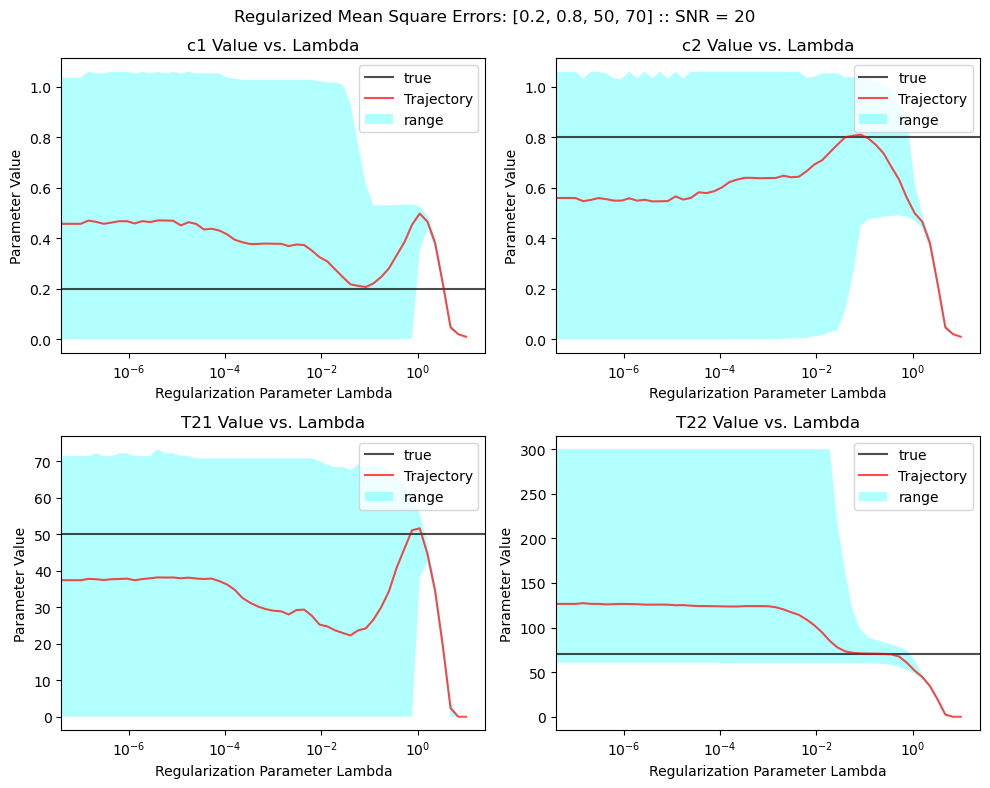

In [23]:
single_meanParam = np.mean(estimates_rs_ro[pC_index,:,:,:], axis = 0)
single_stdParam = np.std(estimates_rs_ro[pC_index,:,:,:], axis = 0)
single_minParam = np.min(estimates_rs_ro[pC_index,:,:,:], axis = 0)
single_maxParam = np.max(estimates_rs_ro[pC_index,:,:,:], axis = 0)

plt.rc('font', size = 10)
fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)
fig.suptitle('Regularized Mean Square Errors: ' + str(pCombo_oi) + ' :: SNR = ' + str(SNR_option) + post_norm_blurb)
for i in range(4):
    ax[i//2, i%2].axhline(y = pCombo_oi[i], label = "true", alpha = 0.7, color = "black")
    ax[i//2, i%2].semilogx(lambdas, single_meanParam[:,i], label = "Trajectory", alpha = 0.7, color = "red")
    ax[i//2, i%2].fill_between(lambdas, single_minParam[:,i], single_maxParam[:,i], color = 'cyan', alpha = 0.3, lw=0, label = 'range')
    ax[i//2, i%2].set_xlabel('Regularization Parameter Lambda')
    ax[i//2, i%2].set_ylabel('Parameter Value')
    ax[i//2, i%2].set_title(param_name_list[i] + ' Value vs. Lambda')
    ax[i//2, i%2].legend()
plt.show()

# Show Improvements

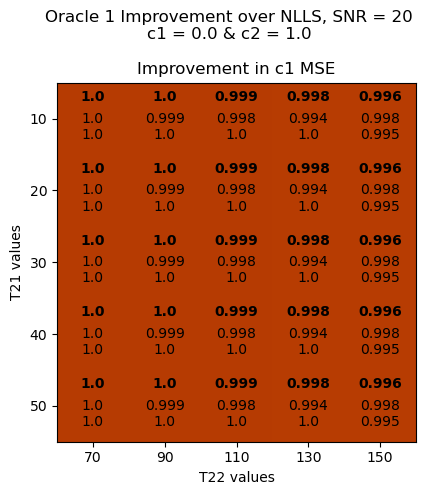

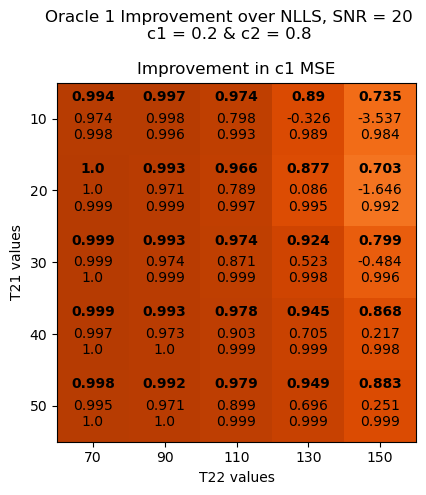

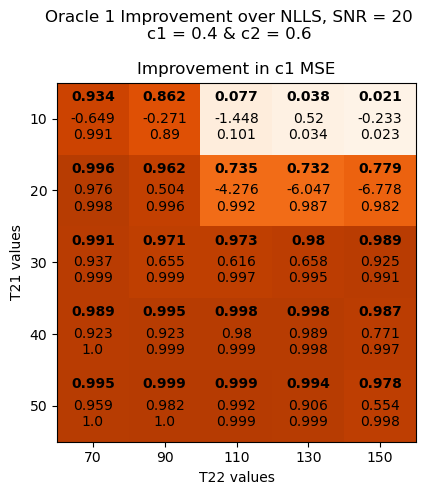

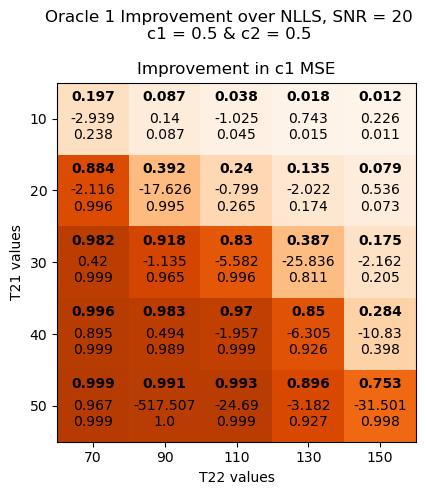

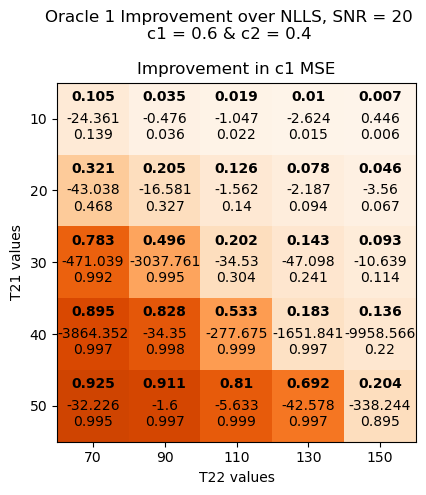

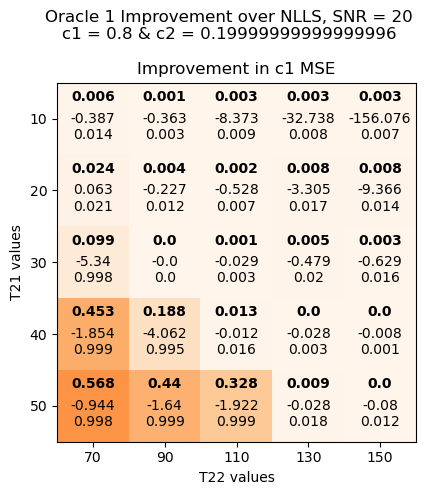

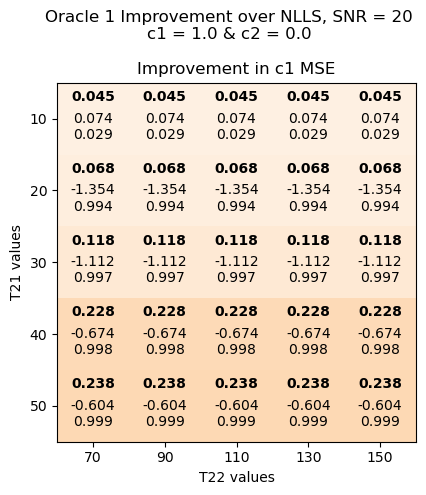

In [19]:
if eval_orc_avg:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), 4]

    POI = 0
    orcAvg_imp_MSE = np.reshape(orcAvg_imp_MSE,size_array)
    orcAvg_imp_bias_sq = np.reshape(orcAvg_imp_bias_sq,size_array)
    orcAvg_imp_var = np.reshape(orcAvg_imp_var,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        plt.rc('font', size = 10)
        fig.suptitle(f"Oracle 1 Improvement over NLLS, SNR = {SNR_option}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}" + post_norm_blurb)
        imc1 = ax.imshow(orcAvg_imp_MSE[c1_VOI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(orcAvg_imp_MSE[c1_VOI,i,j,POI], 3)}")
                comp_summary = (f"\n{round(orcAvg_imp_bias_sq[c1_VOI,i,j,POI], 3)}\n{round(orcAvg_imp_var[c1_VOI,i,j,POI], 3)}")
                text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

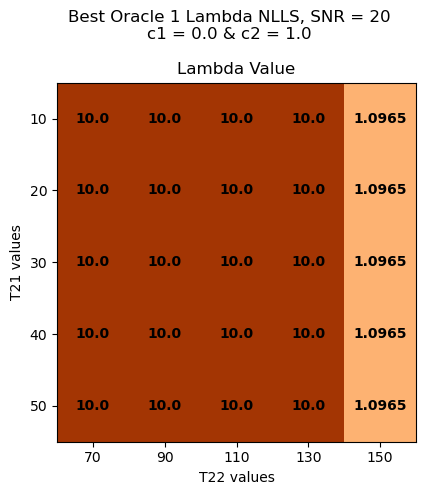

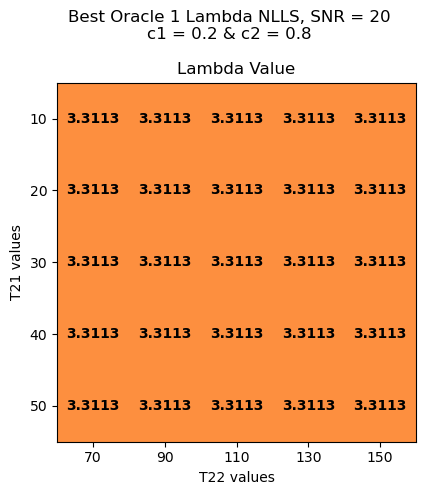

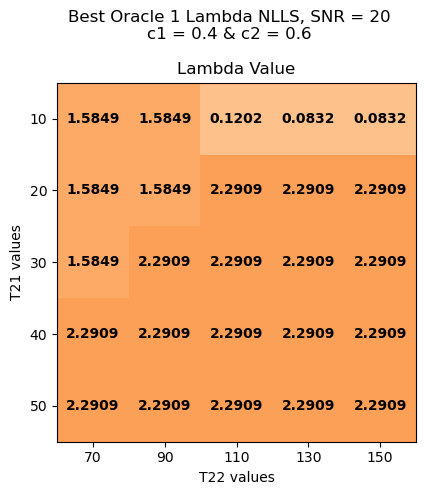

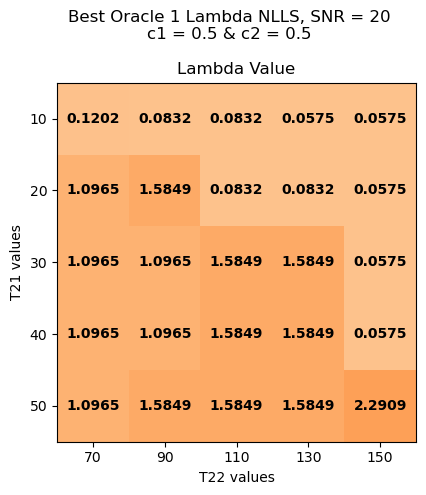

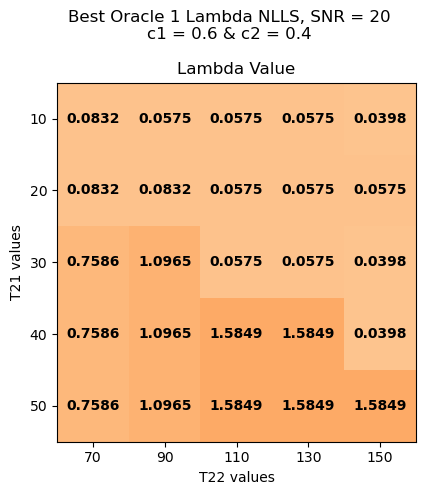

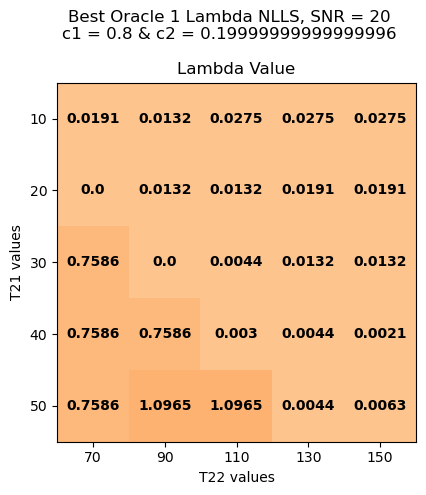

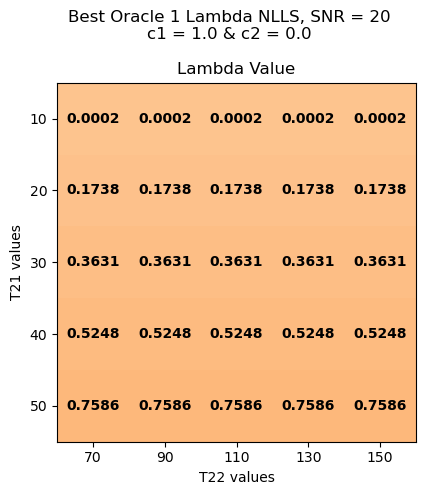

In [20]:
if eval_orc_avg:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), 4]

    POI = 0
    minMSE_orcAvg_lamb = np.reshape(minMSE_orcAvg_lamb ,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        fig.suptitle(f"Best Oracle 1 Lambda NLLS, SNR = {SNR_option}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}" + post_norm_blurb)
        imc1 = ax.imshow(minMSE_orcAvg_lamb[c1_VOI,:,:,POI], cmap = 'Oranges', vmin = -5, vmax = 12)

        ax.set_title('Lambda Value')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                lamb_summary = (f"{round(minMSE_orcAvg_lamb[c1_VOI,i,j, POI], 4)}")
                text = ax.text(j, i, lamb_summary, ha="center", va="center", color="black", weight = "bold")

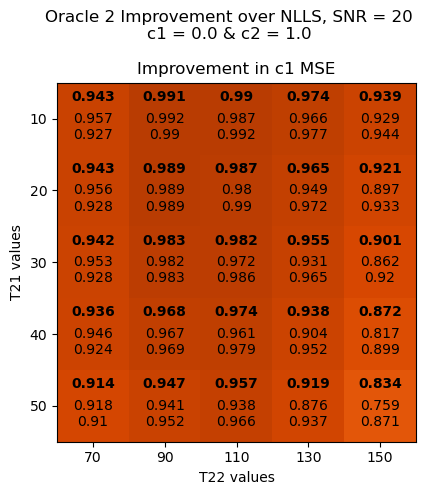

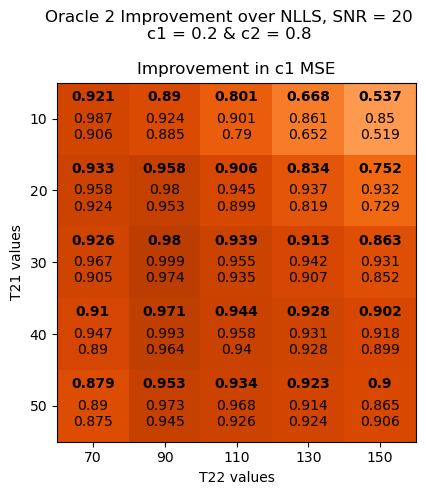

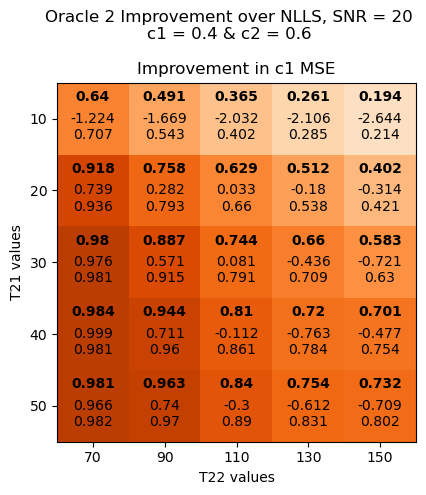

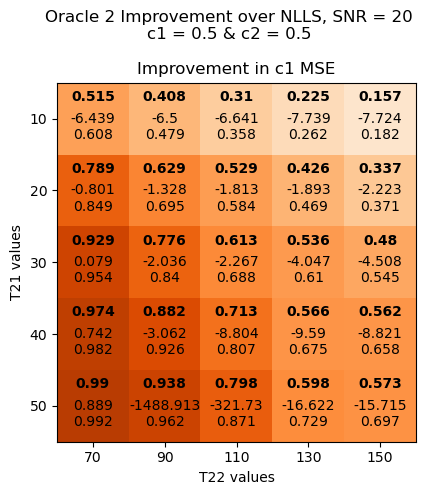

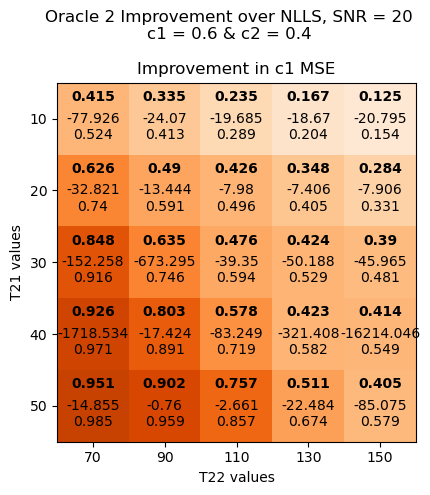

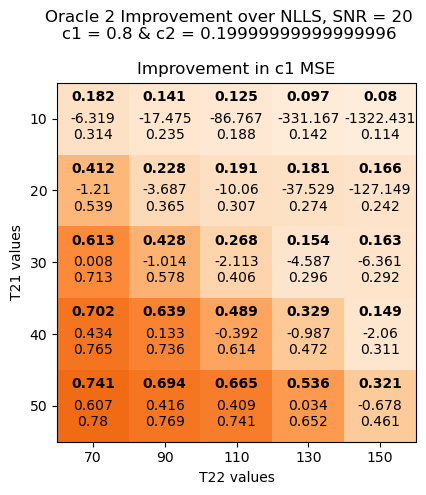

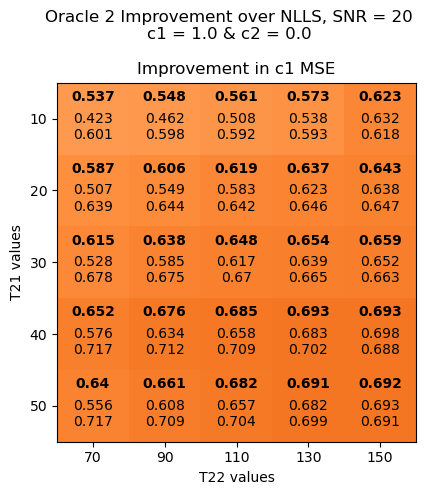

In [21]:
if eval_minErr:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), 4]

    POI = 0
    minErr_agg_imp_MSE = np.reshape(minErr_agg_imp_MSE,size_array)
    minErr_agg_imp_bias_sq = np.reshape(minErr_agg_imp_bias_sq,np.abs(size_array))
    minErr_agg_imp_var = np.reshape(minErr_agg_imp_var,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        plt.rc('font', size = 10)
        fig.suptitle(f"Oracle 2 Improvement over NLLS, SNR = {SNR_option}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}" + post_norm_blurb)
        imc1 = ax.imshow(minErr_agg_imp_MSE[c1_VOI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(minErr_agg_imp_MSE[c1_VOI,i,j,POI], 3)}")
                comp_summary = (f"\n{round(minErr_agg_imp_bias_sq[c1_VOI,i,j,POI], 3)}\n{round(minErr_agg_imp_var[c1_VOI,i,j,POI], 3)}")
                text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

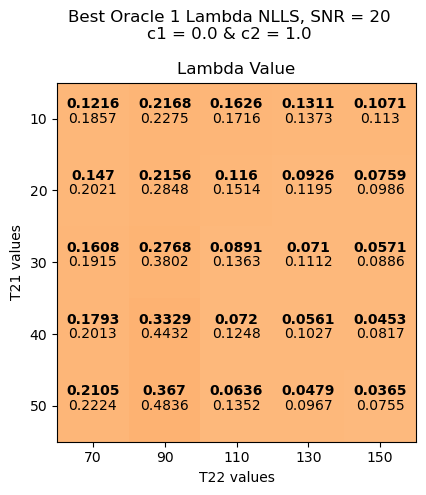

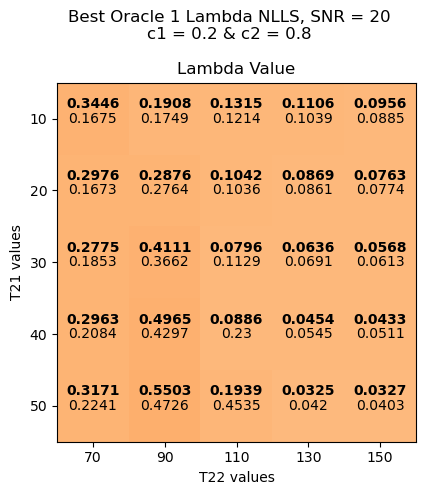

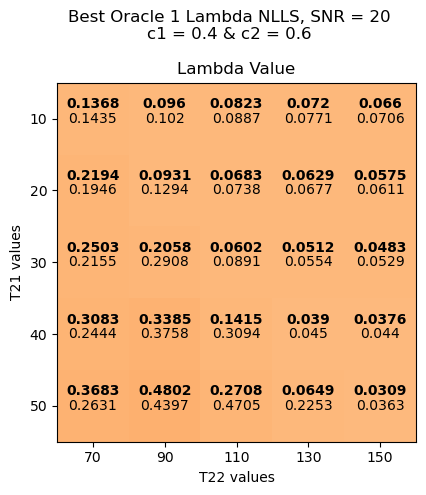

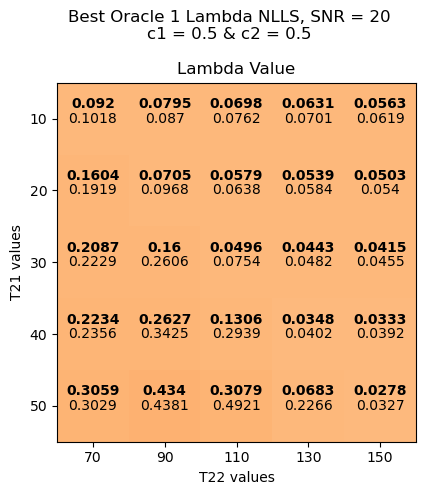

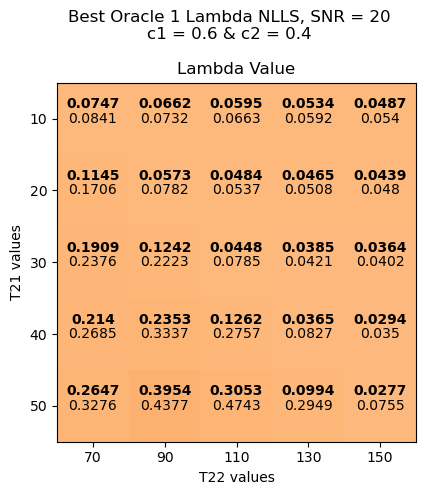

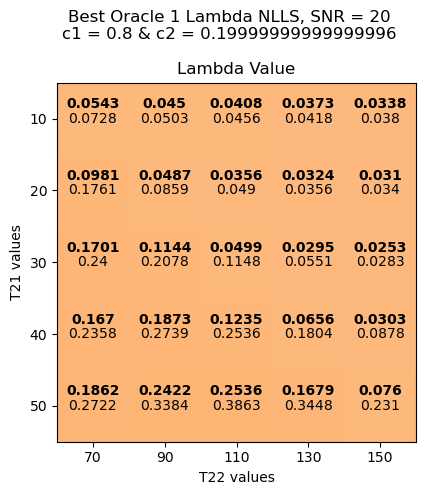

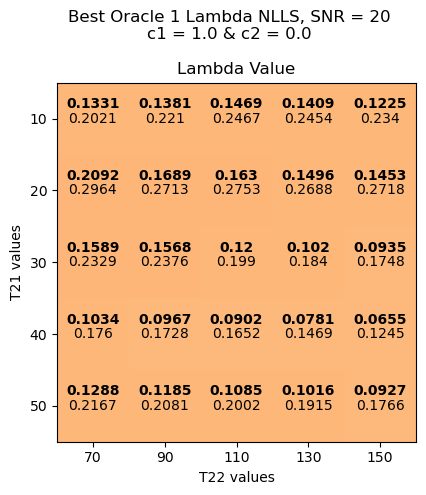

In [22]:
if eval_minErr:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set)]

    avg_lambda = np.mean(minErr_orcNR_agg_lamb, axis = -1)
    std_lambda = np.std(minErr_orcNR_agg_lamb, axis = -1)

    POI = 0
    avg_minErr_agg_lamb = np.reshape(avg_lambda, size_array)
    std_minErr_agg_lamb = np.reshape(std_lambda, size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        fig.suptitle(f"Best Oracle 1 Lambda NLLS, SNR = {SNR_option}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}" + post_norm_blurb)
        imc1 = ax.imshow(avg_minErr_agg_lamb[c1_VOI,:,:], cmap = 'Oranges', vmin = -5, vmax = 10)

        ax.set_title('Lambda Value')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                lamb_summary = (f"{round(avg_minErr_agg_lamb[c1_VOI,i,j], 4)}")
                lamb_std = (f"{round(std_minErr_agg_lamb[c1_VOI,i,j], 4)}")
                text = ax.text(j, i - 0.2, lamb_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, lamb_std, ha="center", va="center", color="black")

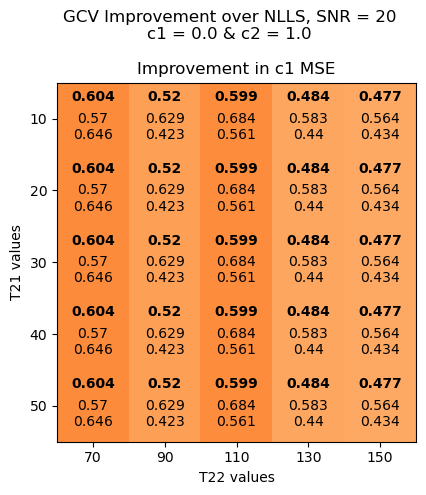

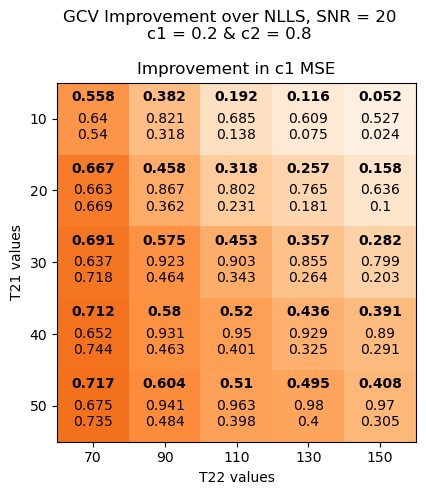

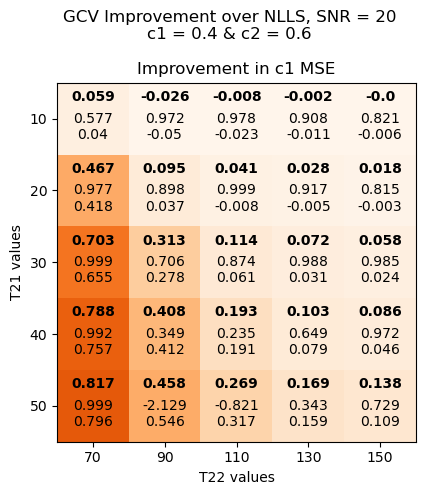

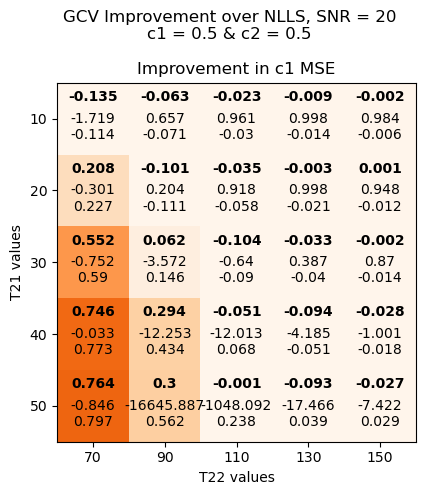

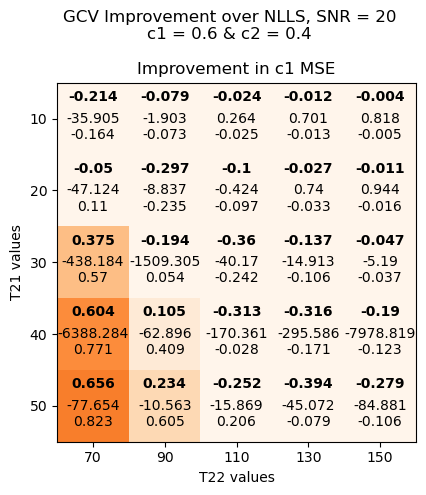

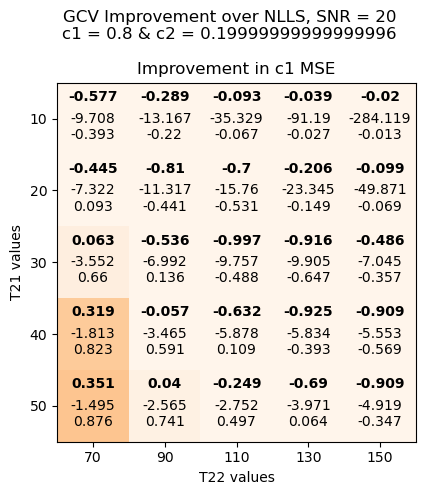

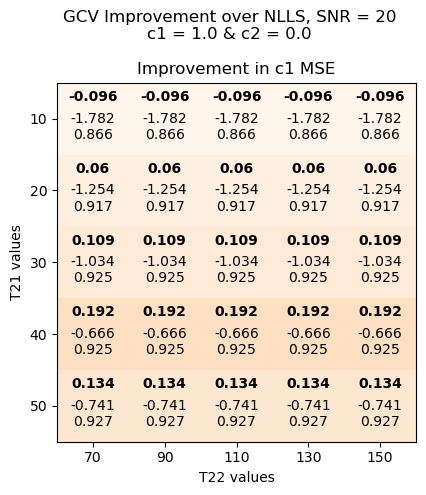

In [23]:
if eval_GCV:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), 4]

    POI = 0
    GCV_imp_MSE = np.reshape(GCV_imp_MSE,size_array)
    GCV_imp_bias_sq = np.reshape(GCV_imp_bias_sq,size_array)
    GCV_imp_var = np.reshape(GCV_imp_var,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        fig.suptitle(f"GCV Improvement over NLLS, SNR = {SNR_option}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}" + post_norm_blurb)
        imc1 = ax.imshow(GCV_imp_MSE[c1_VOI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(GCV_imp_MSE[c1_VOI,i,j,POI], 3)}")
                comp_summary = (f"\n{round(GCV_imp_bias_sq[c1_VOI,i,j,POI], 3)}\n{round(GCV_imp_var[c1_VOI,i,j,POI], 3)}")
                text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

    # with h5py.File(f'SimulationSets//GCV//streamlined_fig2set_{SNR}_' + day + month + year +'.hdf5','a') as f:
    #     #Save a data set
    #     # dset = f.create_dataset('runInfo',data=runInfo)
    #     dset = f.create_dataset('MSE_array',data=GCV_MSE)
    #     dset = f.create_dataset('lambda_array',data=GCV_lambdas)
    #     dset = f.create_dataset('improvement_array',data=GCV_imp_MSE)
    #     dset = f.create_dataset('bias_improvement_array',data=GCV_imp_bias)
    #     dset = f.create_dataset('variance_improvement_array',data=GCV_imp_var)



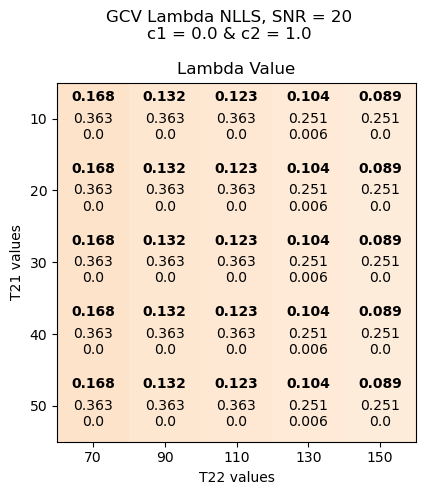

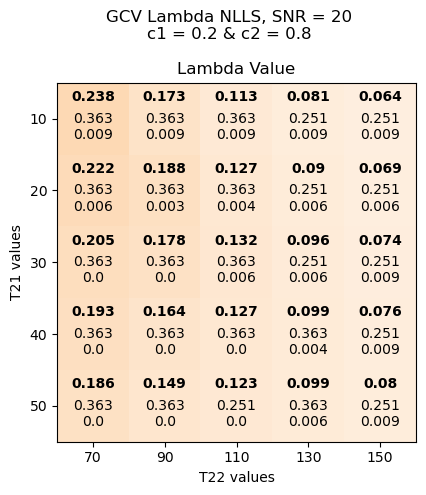

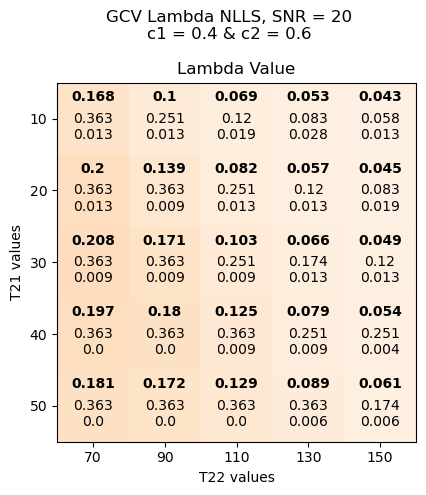

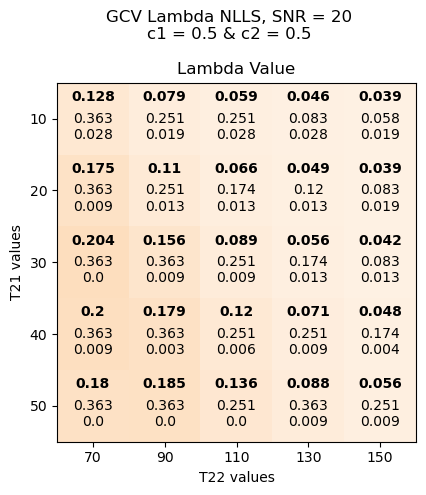

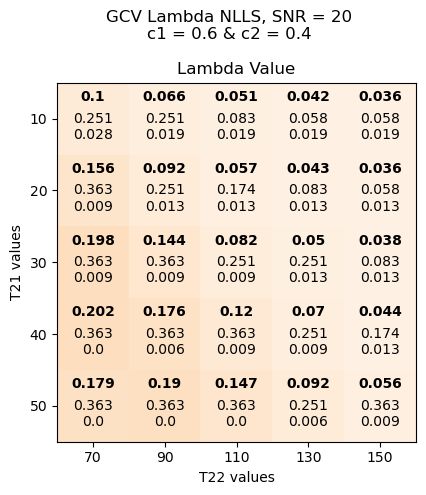

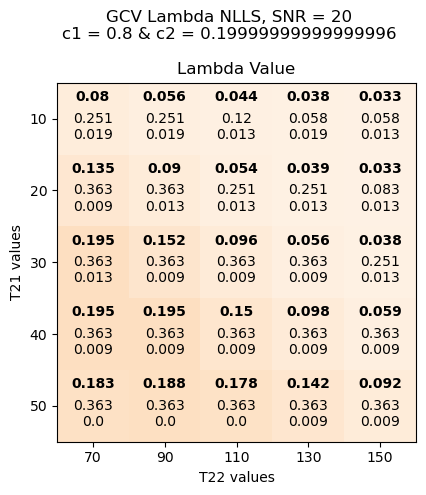

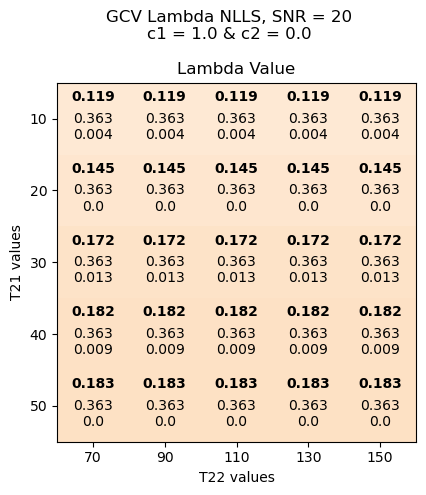

In [24]:
if eval_GCV:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set)]

    POI = 0
    GCV_lambdas_mean = np.reshape(np.mean(GCV_lambdas, axis = 1), size_array)
    GCV_lambdas_min = np.reshape(np.min(GCV_lambdas, axis = 1), size_array)
    GCV_lambdas_max = np.reshape(np.max(GCV_lambdas, axis = 1), size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        fig.suptitle(f"GCV Lambda NLLS, SNR = {SNR_option}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}" + post_norm_blurb)
        imc1 = ax.imshow(GCV_lambdas_mean[c1_VOI,:,:], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Lambda Value')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                lamb_summary = (f"{round(GCV_lambdas_mean[c1_VOI,i,j], 3)}")
                comp_summary = (f"\n{round(GCV_lambdas_max[c1_VOI,i,j], 3)}\n{round(GCV_lambdas_min[c1_VOI,i,j], 3)}")
                text = ax.text(j, i-0.3, lamb_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")